CRISPR SCREEN DATA ANALYSIS PIPELINE

Step 1: Creating sample CRISPR data...
Sample data created: sample_crispr_data.csv
  - Total genes: 50
  - Total sgRNAs: 200
  - Depleted genes: ['Zap70', 'Cd28', 'Dlat', 'Lck', 'Cd3e']
  - Enriched genes: ['Kdr', 'Pdcd1', 'Adora2a', 'Ctla4', 'Lag3']

Step 2: Analyzing CRISPR screen data...
Reading CRISPR data from sample_crispr_data.csv...

Data Summary:
  Total sgRNAs: 200
  Total genes: 50
  Significant genes (FDR < 0.05): 11
  Depleted genes: 6
  Enriched genes: 5

Creating visualizations...


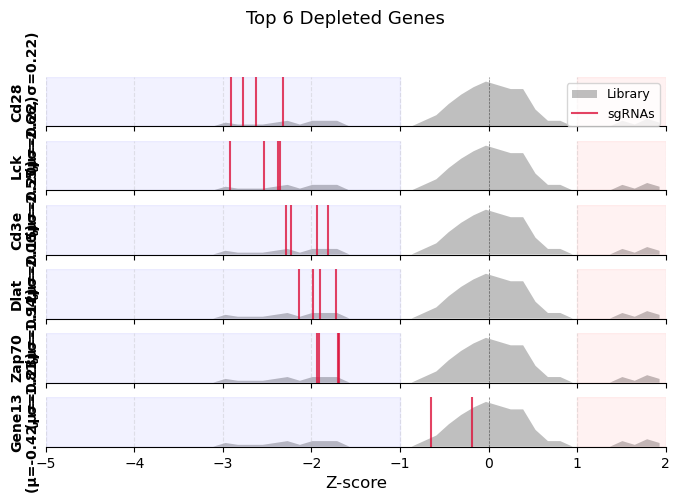

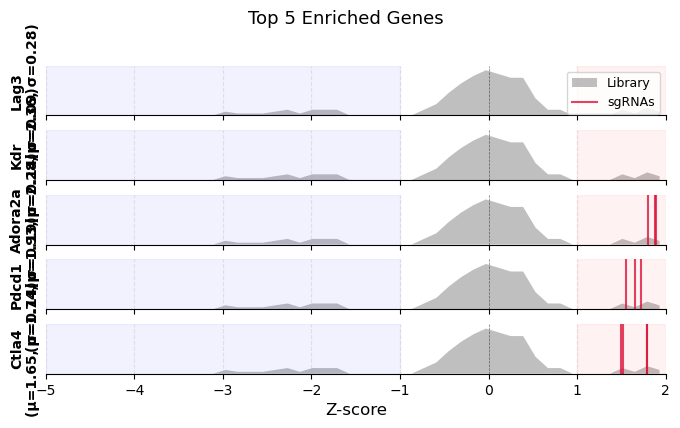

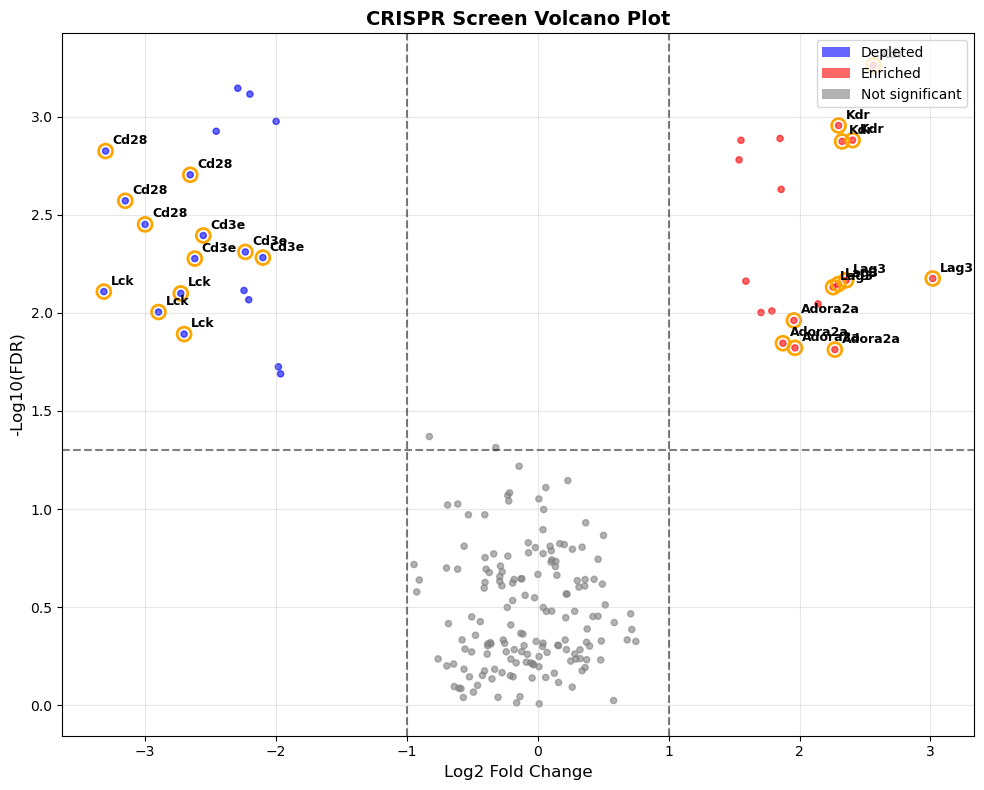

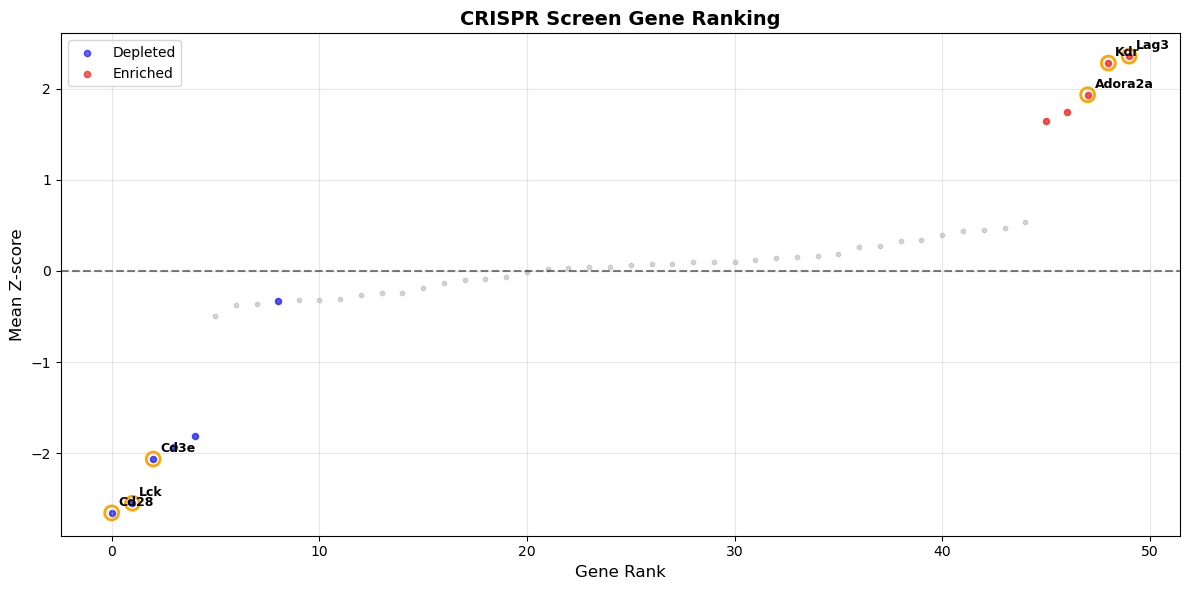

Gene lists exported to crispr_output
  - Depleted genes: 6
  - Enriched genes: 5

TOP SIGNIFICANT HITS

Top 5 Depleted Genes:
           logFC_mean  zscore_mean  FDR_min
gene_name                                  
Cd28          -3.0266      -2.6551   0.0015
Lck           -2.9101      -2.5490   0.0078
Cd3e          -2.3771      -2.0641   0.0040
Dlat          -2.2365      -1.9361   0.0007
Zap70         -2.0994      -1.8113   0.0077

Top 5 Enriched Genes:
           logFC_mean  zscore_mean  FDR_min
gene_name                                  
Ctla4          1.7001       1.6461   0.0013
Pdcd1          1.8060       1.7424   0.0069
Adora2a        2.0161       1.9336   0.0109
Kdr            2.3981       2.2812   0.0005
Lag3           2.4812       2.3568   0.0067

QUICK CHECK: GENES OF INTEREST

QUICK GENE STATUS CHECK
✓ Zap70           ↓ LogFC:  -2.10, FDR: 0.0077, sgRNAs: 4
✓ Cd28            ↓ LogFC:  -3.03, FDR: 0.0015, sgRNAs: 4
✓ Kdr             ↑ LogFC:   2.40, FDR: 0.0005, sgRNAs: 4
✓ Pd

UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f4ca' in position 446: character maps to <undefined>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# ==================== DATA READING AND PROCESSING ====================

def read_crispr_data(filepath, sep=',', fdr_threshold=0.05, logfc_threshold=None):
    """
    Read CRISPR screen data from CSV file and process for visualization.
    
    Parameters:
    -----------
    filepath : str
        Path to CSV file containing CRISPR screen results
    sep : str
        Delimiter for CSV file (default: ',')
    fdr_threshold : float
        FDR cutoff for significant hits (default: 0.05)
    logfc_threshold : float or None
        Log fold change threshold for filtering (default: None)
    
    Returns:
    --------
    dict : Dictionary containing processed data
        - 'raw_data': Original DataFrame
        - 'genes_data': Dictionary with gene names as keys and sgRNA Z-scores as values
        - 'library_zscores': Z-scores for entire library
        - 'significant_genes': List of genes passing FDR threshold
        - 'depleted_genes': Genes with negative mean logFC
        - 'enriched_genes': Genes with positive mean logFC
    """
    
    # Read CSV file
    try:
        df = pd.read_csv(filepath, sep=sep)
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {filepath}")
    except Exception as e:
        raise Exception(f"Error reading file: {e}")
    
    # Check for required columns
    required_cols = ['sgRNA_id', 'gene_name', 'mean', 'logFC', 'p_value', 'FDR']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Calculate Z-scores from logFC
    df['zscore'] = calculate_zscore_from_logfc(df['logFC'].values)
    
    # Filter significant hits based on FDR
    significant_df = df[df['FDR'] <= fdr_threshold].copy()
    
    # Apply logFC threshold if specified
    if logfc_threshold is not None:
        significant_df = significant_df[np.abs(significant_df['logFC']) >= logfc_threshold]
    
    # Group sgRNAs by gene
    genes_data = {}
    for gene in significant_df['gene_name'].unique():
        gene_df = significant_df[significant_df['gene_name'] == gene]
        genes_data[gene] = gene_df['zscore'].values.tolist()
    
    # Separate depleted and enriched genes
    depleted_genes = {}
    enriched_genes = {}
    
    for gene, zscores in genes_data.items():
        mean_zscore = np.mean(zscores)
        if mean_zscore < 0:
            depleted_genes[gene] = zscores
        else:
            enriched_genes[gene] = zscores
    
    # Get library-wide Z-score distribution
    library_zscores = df['zscore'].values
    
    # Create summary statistics
    summary_stats = calculate_gene_statistics(df)
    
    return {
        'raw_data': df,
        'genes_data': genes_data,
        'library_zscores': library_zscores,
        'significant_genes': list(genes_data.keys()),
        'depleted_genes': depleted_genes,
        'enriched_genes': enriched_genes,
        'summary_stats': summary_stats
    }


def calculate_zscore_from_logfc(logfc_values):
    """
    Calculate Z-scores from log fold change values.
    
    Parameters:
    -----------
    logfc_values : array-like
        Log fold change values
    
    Returns:
    --------
    array : Z-scores
    """
    # Remove NaN values for calculation
    valid_logfc = logfc_values[~np.isnan(logfc_values)]
    
    # Calculate mean and standard deviation
    mean_logfc = np.mean(valid_logfc)
    std_logfc = np.std(valid_logfc)
    
    # Calculate Z-scores
    if std_logfc > 0:
        zscores = (logfc_values - mean_logfc) / std_logfc
    else:
        zscores = np.zeros_like(logfc_values)
    
    return zscores


def calculate_gene_statistics(df):
    """
    Calculate summary statistics for each gene.
    
    Parameters:
    -----------
    df : DataFrame
        CRISPR screen data with gene annotations
    
    Returns:
    --------
    DataFrame : Summary statistics per gene
    """
    gene_stats = df.groupby('gene_name').agg({
        'logFC': ['mean', 'std', 'min', 'max', 'count'],
        'zscore': ['mean', 'std'],
        'FDR': 'min',
        'p_value': 'min'
    }).round(4)
    
    # Flatten column names
    gene_stats.columns = ['_'.join(col).strip() for col in gene_stats.columns.values]
    
    # Sort by mean logFC
    gene_stats = gene_stats.sort_values('logFC_mean')
    
    return gene_stats


def filter_top_hits(crispr_data, n_top=10, by='zscore', direction='both'):
    """
    Filter top depleted or enriched hits from CRISPR data.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    n_top : int
        Number of top hits to select (default: 10)
    by : str
        Metric to sort by: 'zscore', 'logFC', or 'FDR' (default: 'zscore')
    direction : str
        'depleted', 'enriched', or 'both' (default: 'both')
    
    Returns:
    --------
    dict : Filtered genes with their Z-scores
    """
    summary = crispr_data['summary_stats']
    
    if by == 'zscore':
        sort_col = 'zscore_mean'
    elif by == 'logFC':
        sort_col = 'logFC_mean'
    elif by == 'FDR':
        sort_col = 'FDR_min'
    else:
        raise ValueError("by must be 'zscore', 'logFC', or 'FDR'")
    
    if direction == 'depleted':
        top_genes = summary.nsmallest(n_top, sort_col).index
    elif direction == 'enriched':
        top_genes = summary.nlargest(n_top, sort_col).index
    elif direction == 'both':
        depleted = summary.nsmallest(n_top//2, sort_col).index
        enriched = summary.nlargest(n_top//2, sort_col).index
        top_genes = list(depleted) + list(enriched)
    else:
        raise ValueError("direction must be 'depleted', 'enriched', or 'both'")
    
    # Get Z-scores for selected genes
    filtered_genes = {}
    genes_data = crispr_data['genes_data']
    
    for gene in top_genes:
        if gene in genes_data:
            filtered_genes[gene] = genes_data[gene]
    
    return filtered_genes


# ==================== VISUALIZATION FUNCTIONS ====================

def plot_zscore_depleted_hits(genes_data, library_distribution=None, figsize=(8, 6), 
                             title=None, show_stats=True):
    """
    Create Z-score plots for depleted gene hits with background distribution.
    
    Parameters:
    -----------
    genes_data : dict
        Dictionary with gene names as keys and sgRNA z-scores as values
    library_distribution : array-like, optional
        Z-scores for the entire library background
    figsize : tuple
        Figure size (width, height)
    title : str, optional
        Custom title for the plot
    show_stats : bool
        Whether to show mean and std for each gene
    """
    
    # If no library distribution provided, simulate one
    if library_distribution is None:
        np.random.seed(42)
        library_distribution = np.random.normal(0, 1, 10000)
    
    # Set up the figure
    n_genes = len(genes_data)
    fig, axes = plt.subplots(n_genes, 1, figsize=figsize, 
                            sharex=True, gridspec_kw={'hspace': 0.3})
    
    if n_genes == 1:
        axes = [axes]
    
    # Define colors
    background_color = '#808080'  # Grey
    sgrna_color = '#DC143C'  # Crimson red
    
    # X-axis range
    x_min, x_max = -5, 2
    
    for idx, (gene_name, sgrna_scores) in enumerate(genes_data.items()):
        ax = axes[idx]
        
        # Create histogram data for background distribution
        hist_counts, bin_edges = np.histogram(library_distribution, 
                                             bins=50, 
                                             range=(x_min, x_max))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Normalize histogram for better visualization
        hist_counts = hist_counts / hist_counts.max()
        
        # Plot as a filled area (horizontal distribution)
        ax.fill_between(bin_centers, 0, hist_counts, 
                       color=background_color, alpha=0.5, 
                       edgecolor='none', label='Library' if idx == 0 else '')
        
        # Add vertical lines for each sgRNA
        for i, sgrna_zscore in enumerate(sgrna_scores):
            ax.axvline(x=sgrna_zscore, color=sgrna_color, 
                      linewidth=1.5, alpha=0.8, linestyle='-',
                      label='sgRNAs' if idx == 0 and i == 0 else '')
        
        # Add gene name and stats
        if show_stats:
            mean_z = np.mean(sgrna_scores)
            std_z = np.std(sgrna_scores)
            label = f"{gene_name}\n(μ={mean_z:.2f}, σ={std_z:.2f})"
        else:
            label = gene_name
        
        ax.set_ylabel(label, fontsize=10, fontweight='bold')
        ax.set_ylim(0, 1.1)
        ax.set_xlim(x_min, x_max)
        
        # Remove y-axis ticks and labels (except gene name)
        ax.set_yticks([])
        
        # Add grid for better readability
        ax.grid(True, axis='x', alpha=0.3, linestyle='--')
        
        # Add shading to indicate depletion/enrichment regions
        ax.axvspan(x_min, -1, alpha=0.05, color='blue')  # Depleted region
        ax.axvspan(1, x_max, alpha=0.05, color='red')     # Enriched region
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        # Add vertical line at 0 for reference
        ax.axvline(x=0, color='black', linewidth=0.5, alpha=0.5, linestyle='--')
    
    # Set x-label only for the bottom plot
    axes[-1].set_xlabel('Z-score', fontsize=12)
    
    # Add title
    if title:
        fig.suptitle(title, fontsize=13, y=1.02)
    else:
        fig.suptitle('Gene Z-score Analysis\n(Grey: Library Background, Red: Individual sgRNAs)', 
                     fontsize=13, y=1.02)
    
    # Add legend
    if n_genes > 0:
        axes[0].legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    return fig, axes


def plot_volcano(crispr_data, fdr_threshold=0.05, logfc_threshold=1, 
                highlight_genes=None, figsize=(10, 8)):
    """
    Create volcano plot from CRISPR screen data.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    fdr_threshold : float
        FDR threshold for significance
    logfc_threshold : float
        Log fold change threshold
    highlight_genes : list
        Genes to highlight in the plot
    figsize : tuple
        Figure size
    """
    df = crispr_data['raw_data'].copy()
    
    # Calculate -log10(FDR)
    df['neg_log_fdr'] = -np.log10(df['FDR'] + 1e-10)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors
    colors = []
    for _, row in df.iterrows():
        if row['FDR'] < fdr_threshold and row['logFC'] < -logfc_threshold:
            colors.append('blue')  # Significantly depleted
        elif row['FDR'] < fdr_threshold and row['logFC'] > logfc_threshold:
            colors.append('red')   # Significantly enriched
        else:
            colors.append('grey')  # Not significant
    
    # Create scatter plot
    scatter = ax.scatter(df['logFC'], df['neg_log_fdr'], 
                        c=colors, alpha=0.6, s=20)
    
    # Add threshold lines
    ax.axhline(y=-np.log10(fdr_threshold), color='black', 
              linestyle='--', alpha=0.5, label=f'FDR = {fdr_threshold}')
    ax.axvline(x=-logfc_threshold, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=logfc_threshold, color='black', linestyle='--', alpha=0.5)
    
    # Highlight specific genes if provided
    if highlight_genes:
        for gene in highlight_genes:
            gene_data = df[df['gene_name'] == gene]
            if not gene_data.empty:
                ax.scatter(gene_data['logFC'], gene_data['neg_log_fdr'],
                          s=100, facecolors='none', edgecolors='orange', linewidth=2)
                for _, row in gene_data.iterrows():
                    ax.annotate(gene, (row['logFC'], row['neg_log_fdr']),
                               xytext=(5, 5), textcoords='offset points',
                               fontsize=9, fontweight='bold')
    
    # Labels and title
    ax.set_xlabel('Log2 Fold Change', fontsize=12)
    ax.set_ylabel('-Log10(FDR)', fontsize=12)
    ax.set_title('CRISPR Screen Volcano Plot', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.6, label='Depleted'),
        Patch(facecolor='red', alpha=0.6, label='Enriched'),
        Patch(facecolor='grey', alpha=0.6, label='Not significant')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig, ax


def plot_sgRNA_distribution(crispr_data, gene_name, figsize=(10, 4)):
    """
    Plot distribution of sgRNAs for a specific gene compared to library.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    gene_name : str
        Name of the gene to analyze
    figsize : tuple
        Figure size
    """
    df = crispr_data['raw_data']
    gene_df = df[df['gene_name'] == gene_name]
    
    if gene_df.empty:
        print(f"Gene {gene_name} not found in data")
        return None
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Z-score distribution
    ax1.hist(crispr_data['library_zscores'], bins=50, alpha=0.5, 
            color='grey', label='All sgRNAs', density=True)
    ax1.hist(gene_df['zscore'], bins=20, alpha=0.7, 
            color='red', label=f'{gene_name} sgRNAs', density=True)
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Z-score')
    ax1.set_ylabel('Density')
    ax1.set_title(f'{gene_name} sgRNA Z-score Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Individual sgRNA values
    sgRNA_ids = gene_df['sgRNA_id'].values
    zscores = gene_df['zscore'].values
    
    ax2.barh(range(len(sgRNA_ids)), zscores, color='red', alpha=0.7)
    ax2.set_yticks(range(len(sgRNA_ids)))
    ax2.set_yticklabels(sgRNA_ids, fontsize=8)
    ax2.set_xlabel('Z-score')
    ax2.set_title(f'Individual sgRNA Z-scores for {gene_name}')
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add mean line
    mean_z = np.mean(zscores)
    ax2.axvline(x=mean_z, color='blue', linestyle='-', alpha=0.7, 
               label=f'Mean = {mean_z:.2f}')
    ax2.legend()
    
    plt.tight_layout()
    return fig, (ax1, ax2)


def plot_rank_plot(crispr_data, metric='zscore_mean', highlight_genes=None, 
                  figsize=(12, 6)):
    """
    Create rank plot showing all genes ordered by effect size.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    metric : str
        Metric to use for ranking ('zscore_mean' or 'logFC_mean')
    highlight_genes : list
        Genes to highlight in the plot
    figsize : tuple
        Figure size
    """
    summary = crispr_data['summary_stats'].copy()
    summary = summary.sort_values(metric)
    summary['rank'] = range(len(summary))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot all genes
    ax.scatter(summary['rank'], summary[metric], c='grey', alpha=0.3, s=10)
    
    # Highlight significant genes
    sig_genes = crispr_data['significant_genes']
    sig_summary = summary[summary.index.isin(sig_genes)]
    
    # Color by depletion/enrichment
    depleted = sig_summary[sig_summary[metric] < 0]
    enriched = sig_summary[sig_summary[metric] > 0]
    
    ax.scatter(depleted['rank'], depleted[metric], c='blue', alpha=0.6, s=20, label='Depleted')
    ax.scatter(enriched['rank'], enriched[metric], c='red', alpha=0.6, s=20, label='Enriched')
    
    # Highlight specific genes
    if highlight_genes:
        for gene in highlight_genes:
            if gene in summary.index:
                gene_data = summary.loc[gene]
                ax.scatter(gene_data['rank'], gene_data[metric], 
                          s=100, facecolors='none', edgecolors='orange', linewidth=2)
                ax.annotate(gene, (gene_data['rank'], gene_data[metric]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=9, fontweight='bold')
    
    # Add reference line at 0
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Labels and title
    ax.set_xlabel('Gene Rank', fontsize=12)
    ax.set_ylabel('Mean Z-score' if metric == 'zscore_mean' else 'Mean Log2FC', fontsize=12)
    ax.set_title('CRISPR Screen Gene Ranking', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    return fig, ax


def quick_gene_check(crispr_data, gene_list):
    """
    Quick check to see if genes are in dataset and their status.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    gene_list : list or str
        Gene(s) to check
    
    Returns:
    --------
    DataFrame : Quick summary of gene status
    """
    if isinstance(gene_list, str):
        gene_list = [gene_list]
    
    results = []
    for gene in gene_list:
        status = {
            'Gene': gene,
            'In_Dataset': False,
            'Is_Significant': False,
            'Direction': 'N/A',
            'Mean_LogFC': np.nan,
            'Min_FDR': np.nan,
            'Num_sgRNAs': 0
        }
        
        # Check if gene exists
        if gene in crispr_data['raw_data']['gene_name'].values:
            status['In_Dataset'] = True
            gene_data = crispr_data['raw_data'][crispr_data['raw_data']['gene_name'] == gene]
            status['Num_sgRNAs'] = len(gene_data)
            status['Mean_LogFC'] = gene_data['logFC'].mean()
            status['Min_FDR'] = gene_data['FDR'].min()
            
            # Check significance and direction
            if gene in crispr_data['significant_genes']:
                status['Is_Significant'] = True
                if gene in crispr_data['depleted_genes']:
                    status['Direction'] = 'Depleted'
                elif gene in crispr_data['enriched_genes']:
                    status['Direction'] = 'Enriched'
            else:
                if status['Mean_LogFC'] < 0:
                    status['Direction'] = 'Trend_Depleted'
                else:
                    status['Direction'] = 'Trend_Enriched'
        
        results.append(status)
    
    df = pd.DataFrame(results)
    
    # Display with formatting
    print("\n" + "="*60)
    print("QUICK GENE STATUS CHECK")
    print("="*60)
    
    for _, row in df.iterrows():
        if row['In_Dataset']:
            symbol = "✓" if row['Is_Significant'] else "○"
            direction = "↓" if 'Depleted' in row['Direction'] else "↑" if 'Enriched' in row['Direction'] else "→"
            print(f"{symbol} {row['Gene']:15s} {direction} "
                  f"LogFC: {row['Mean_LogFC']:6.2f}, FDR: {row['Min_FDR']:.4f}, "
                  f"sgRNAs: {row['Num_sgRNAs']}")
        else:
            print(f"✗ {row['Gene']:15s} - NOT FOUND IN DATASET")
    
    return df


# ==================== GENE-SPECIFIC ANALYSIS FUNCTIONS ====================

def analyze_genes_of_interest(crispr_data, gene_list, save_to_file=False, 
                              output_file='genes_of_interest_report.txt'):
    """
    Print detailed information for specific genes of interest.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    gene_list : list or str
        List of gene names or single gene name to analyze
    save_to_file : bool
        Whether to save the report to a file
    output_file : str
        Filename for the report if save_to_file is True
    
    Returns:
    --------
    DataFrame : Summary table of genes of interest
    """
    # Convert single gene to list
    if isinstance(gene_list, str):
        gene_list = [gene_list]
    
    # Get raw data and summary stats
    raw_data = crispr_data['raw_data']
    summary_stats = crispr_data['summary_stats']
    
    # Prepare output
    output_lines = []
    output_lines.append("="*80)
    output_lines.append("GENES OF INTEREST - DETAILED ANALYSIS")
    output_lines.append("="*80)
    output_lines.append(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    output_lines.append(f"Total Genes Requested: {len(gene_list)}")
    output_lines.append("")
    
    # Create summary table
    summary_data = []
    genes_found = []
    genes_not_found = []
    
    for gene in gene_list:
        if gene in summary_stats.index:
            genes_found.append(gene)
        else:
            genes_not_found.append(gene)
    
    # Report missing genes
    if genes_not_found:
        output_lines.append(f"⚠️  Genes NOT FOUND in dataset: {', '.join(genes_not_found)}")
        output_lines.append("")
    
    # Detailed analysis for each found gene
    for gene in genes_found:
        output_lines.append("-"*80)
        output_lines.append(f"GENE: {gene}")
        output_lines.append("-"*80)
        
        # Get gene statistics
        gene_stats = summary_stats.loc[gene]
        gene_data = raw_data[raw_data['gene_name'] == gene]
        
        # Determine significance and direction
        is_significant = gene in crispr_data['significant_genes']
        if gene in crispr_data['depleted_genes']:
            direction = "DEPLETED"
            direction_symbol = "↓"
        elif gene in crispr_data['enriched_genes']:
            direction = "ENRICHED"
            direction_symbol = "↑"
        else:
            direction = "NEUTRAL"
            direction_symbol = "→"
        
        # Print gene-level statistics
        output_lines.append(f"\n📊 GENE-LEVEL STATISTICS:")
        output_lines.append(f"  Status: {direction_symbol} {direction} {'(SIGNIFICANT)' if is_significant else '(NOT SIGNIFICANT)'}")
        output_lines.append(f"  Mean Log2FC: {gene_stats['logFC_mean']:.3f} (σ = {gene_stats['logFC_std']:.3f})")
        output_lines.append(f"  Mean Z-score: {gene_stats['zscore_mean']:.3f} (σ = {gene_stats['zscore_std']:.3f})")
        output_lines.append(f"  Min FDR: {gene_stats['FDR_min']:.4f}")
        output_lines.append(f"  Min p-value: {gene_stats['p_value_min']:.4e}")
        output_lines.append(f"  Number of sgRNAs: {int(gene_stats['logFC_count'])}")
        
        # Rank information
        all_genes_sorted = summary_stats.sort_values('zscore_mean')
        gene_rank = list(all_genes_sorted.index).index(gene) + 1
        total_genes = len(all_genes_sorted)
        percentile = (gene_rank / total_genes) * 100
        
        output_lines.append(f"  Rank: {gene_rank}/{total_genes} (Percentile: {percentile:.1f}%)")
        
        # Individual sgRNA details
        output_lines.append(f"\n🔬 INDIVIDUAL sgRNA DETAILS:")
        sgRNA_table = gene_data[['sgRNA_id', 'logFC', 'p_value', 'FDR']].copy()
        sgRNA_table['zscore'] = calculate_zscore_from_logfc(gene_data['logFC'].values)
        sgRNA_table = sgRNA_table.sort_values('logFC')
        
        for idx, row in sgRNA_table.iterrows():
            output_lines.append(f"  {row['sgRNA_id']:15s} | LogFC: {row['logFC']:7.3f} | "
                              f"Z-score: {row['zscore']:7.3f} | FDR: {row['FDR']:.4f}")
        
        # Add consistency check
        zscores = sgRNA_table['zscore'].values
        consistency = "HIGH" if np.std(zscores) < 0.5 else "MODERATE" if np.std(zscores) < 1.0 else "LOW"
        output_lines.append(f"\n  sgRNA Consistency: {consistency} (std = {np.std(zscores):.3f})")
        
        # Store summary data
        summary_data.append({
            'Gene': gene,
            'Direction': direction,
            'Significant': is_significant,
            'Mean_LogFC': gene_stats['logFC_mean'],
            'Mean_Zscore': gene_stats['zscore_mean'],
            'Min_FDR': gene_stats['FDR_min'],
            'Num_sgRNAs': int(gene_stats['logFC_count']),
            'Rank': gene_rank,
            'Percentile': f"{percentile:.1f}%",
            'Consistency': consistency
        })
        
        output_lines.append("")
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Add overall summary
    output_lines.append("="*80)
    output_lines.append("SUMMARY TABLE")
    output_lines.append("="*80)
    if not summary_df.empty:
        output_lines.append(summary_df.to_string(index=False))
    else:
        output_lines.append("No genes found in dataset.")
    output_lines.append("")
    
    # Print to console
    report = "\n".join(output_lines)
    print(report)
    
    # Save to file if requested
    if save_to_file and not summary_df.empty:
        with open(output_file, 'w') as f:
            f.write(report)
        print(f"\n📁 Report saved to: {output_file}")
    
    return summary_df


def plot_genes_of_interest(crispr_data, gene_list, plot_type='zscore', 
                           figsize=None, save_figure=False, output_file='genes_of_interest.png'):
    """
    Create visualizations for specific genes of interest.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    gene_list : list or str
        List of gene names or single gene name to plot
    plot_type : str
        Type of plot: 'zscore', 'bar', 'heatmap', or 'combined'
    figsize : tuple
        Figure size (if None, automatically determined)
    save_figure : bool
        Whether to save the figure
    output_file : str
        Filename for the figure if save_figure is True
    
    Returns:
    --------
    matplotlib.figure.Figure : The generated figure
    """
    # Convert single gene to list
    if isinstance(gene_list, str):
        gene_list = [gene_list]
    
    # Filter genes that exist in the data
    genes_data = {}
    for gene in gene_list:
        if gene in crispr_data['genes_data']:
            genes_data[gene] = crispr_data['genes_data'][gene]
        elif gene in crispr_data['raw_data']['gene_name'].values:
            # Gene exists but might not be significant
            gene_df = crispr_data['raw_data'][crispr_data['raw_data']['gene_name'] == gene]
            genes_data[gene] = gene_df['zscore'].values.tolist()
    
    if not genes_data:
        print("No genes found in the dataset!")
        return None
    
    # Set figure size if not provided
    if figsize is None:
        if plot_type == 'zscore':
            figsize = (10, max(4, len(genes_data) * 1.2))
        elif plot_type == 'heatmap':
            figsize = (max(8, len(genes_data) * 0.5), 6)
        else:
            figsize = (12, 6)
    
    if plot_type == 'zscore':
        # Use existing zscore plot function
        fig, axes = plot_zscore_depleted_hits(
            genes_data,
            crispr_data['library_zscores'],
            figsize=figsize,
            title=f"Genes of Interest - Z-score Analysis ({len(genes_data)} genes)",
            show_stats=True
        )
        
    elif plot_type == 'bar':
        # Create bar plot comparing genes
        fig, ax = plt.subplots(figsize=figsize)
        
        gene_names = []
        mean_zscores = []
        std_zscores = []
        colors = []
        
        for gene, zscores in genes_data.items():
            gene_names.append(gene)
            mean_zscores.append(np.mean(zscores))
            std_zscores.append(np.std(zscores))
            
            # Color based on direction
            if np.mean(zscores) < -1:
                colors.append('blue')
            elif np.mean(zscores) > 1:
                colors.append('red')
            else:
                colors.append('grey')
        
        # Create bar plot
        bars = ax.bar(gene_names, mean_zscores, yerr=std_zscores, 
                      capsize=5, color=colors, alpha=0.7, edgecolor='black')
        
        # Add value labels on bars
        for bar, val in zip(bars, mean_zscores):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top')
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.axhline(y=-1, color='blue', linestyle='--', alpha=0.3)
        ax.axhline(y=1, color='red', linestyle='--', alpha=0.3)
        
        ax.set_xlabel('Gene', fontsize=12)
        ax.set_ylabel('Mean Z-score', fontsize=12)
        ax.set_title(f'Genes of Interest - Mean Z-scores ({len(genes_data)} genes)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.xticks(rotation=45, ha='right')
        
    elif plot_type == 'heatmap':
        # Create heatmap of individual sgRNA values
        fig, ax = plt.subplots(figsize=figsize)
        
        # Prepare data matrix
        max_sgrnas = max(len(zscores) for zscores in genes_data.values())
        matrix = np.full((len(genes_data), max_sgrnas), np.nan)
        
        for i, (gene, zscores) in enumerate(genes_data.items()):
            matrix[i, :len(zscores)] = zscores
        
        # Create heatmap
        im = ax.imshow(matrix, cmap='RdBu_r', aspect='auto', vmin=-4, vmax=4)
        
        # Set ticks and labels
        ax.set_xticks(np.arange(max_sgrnas))
        ax.set_xticklabels([f'sgRNA_{i+1}' for i in range(max_sgrnas)])
        ax.set_yticks(np.arange(len(genes_data)))
        ax.set_yticklabels(list(genes_data.keys()))
        
        # Rotate the tick labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Z-score', rotation=270, labelpad=15)
        
        ax.set_title(f'Genes of Interest - sgRNA Heatmap ({len(genes_data)} genes)', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('sgRNA', fontsize=12)
        ax.set_ylabel('Gene', fontsize=12)
        
    elif plot_type == 'combined':
        # Create combined visualization
        fig = plt.figure(figsize=(16, 10))
        
        # Panel 1: Bar plot
        ax1 = plt.subplot(2, 2, 1)
        gene_names = list(genes_data.keys())
        mean_zscores = [np.mean(zscores) for zscores in genes_data.values()]
        colors = ['blue' if z < -1 else 'red' if z > 1 else 'grey' for z in mean_zscores]
        
        ax1.barh(gene_names, mean_zscores, color=colors, alpha=0.7)
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax1.set_xlabel('Mean Z-score')
        ax1.set_title('Mean Z-scores by Gene')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Panel 2: Box plot
        ax2 = plt.subplot(2, 2, 2)
        ax2.boxplot(genes_data.values(), labels=gene_names, vert=False, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax2.set_xlabel('Z-score Distribution')
        ax2.set_title('sgRNA Distribution by Gene')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Panel 3: Heatmap
        ax3 = plt.subplot(2, 2, 3)
        max_sgrnas = max(len(zscores) for zscores in genes_data.values())
        matrix = np.full((len(genes_data), max_sgrnas), np.nan)
        
        for i, zscores in enumerate(genes_data.values()):
            matrix[i, :len(zscores)] = zscores
        
        im = ax3.imshow(matrix, cmap='RdBu_r', aspect='auto', vmin=-4, vmax=4)
        ax3.set_yticks(np.arange(len(genes_data)))
        ax3.set_yticklabels(gene_names)
        ax3.set_xlabel('sgRNA index')
        ax3.set_title('sgRNA Heatmap')
        plt.colorbar(im, ax=ax3, label='Z-score')
        
        # Panel 4: Summary statistics table
        ax4 = plt.subplot(2, 2, 4)
        ax4.axis('tight')
        ax4.axis('off')
        
        # Create summary table
        table_data = []
        for gene, zscores in genes_data.items():
            sig_status = "✓" if gene in crispr_data['significant_genes'] else "✗"
            table_data.append([
                gene,
                f"{np.mean(zscores):.2f}",
                f"{np.std(zscores):.2f}",
                str(len(zscores)),
                sig_status
            ])
        
        table = ax4.table(cellText=table_data,
                         colLabels=['Gene', 'Mean Z', 'Std Z', 'n sgRNA', 'Sig'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        ax4.set_title('Summary Statistics', pad=20)
        
        plt.suptitle(f'Genes of Interest - Comprehensive Analysis ({len(genes_data)} genes)', 
                    fontsize=16, fontweight='bold')
    
    else:
        raise ValueError("plot_type must be 'zscore', 'bar', 'heatmap', or 'combined'")
    
    plt.tight_layout()
    
    # Save figure if requested
    if save_figure:
        fig.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"📁 Figure saved to: {output_file}")
    
    return fig


def compare_gene_groups(crispr_data, gene_groups, group_names=None, 
                        plot_type='violin', figsize=(12, 6)):
    """
    Compare multiple groups of genes (e.g., pathways, gene sets).
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    gene_groups : list of lists
        List where each element is a list of gene names for a group
    group_names : list
        Names for each group (if None, uses Group 1, Group 2, etc.)
    plot_type : str
        'violin', 'box', or 'strip'
    figsize : tuple
        Figure size
    
    Returns:
    --------
    tuple : (figure, DataFrame with statistics)
    """
    if group_names is None:
        group_names = [f"Group {i+1}" for i in range(len(gene_groups))]
    
    # Collect data for each group
    group_data = []
    group_labels = []
    summary_stats = []
    
    for group_idx, (genes, name) in enumerate(zip(gene_groups, group_names)):
        group_zscores = []
        genes_found = 0
        
        for gene in genes:
            if gene in crispr_data['genes_data']:
                group_zscores.extend(crispr_data['genes_data'][gene])
                genes_found += 1
        
        if group_zscores:
            group_data.append(group_zscores)
            group_labels.append(f"{name}\n({genes_found}/{len(genes)} genes)")
            
            # Calculate statistics
            summary_stats.append({
                'Group': name,
                'Genes_Found': genes_found,
                'Genes_Total': len(genes),
                'Mean_Zscore': np.mean(group_zscores),
                'Median_Zscore': np.median(group_zscores),
                'Std_Zscore': np.std(group_zscores),
                'Min_Zscore': np.min(group_zscores),
                'Max_Zscore': np.max(group_zscores),
                'N_sgRNAs': len(group_zscores)
            })
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Main comparison plot
    if plot_type == 'violin':
        parts = ax1.violinplot(group_data, positions=range(len(group_data)),
                               showmeans=True, showmedians=True)
    elif plot_type == 'box':
        bp = ax1.boxplot(group_data, labels=group_labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], plt.cm.Set3(np.linspace(0, 1, len(group_data)))):
            patch.set_facecolor(color)
    elif plot_type == 'strip':
        for i, (data, label) in enumerate(zip(group_data, group_labels)):
            y = np.random.normal(i, 0.04, len(data))
            ax1.scatter(data, y, alpha=0.5, s=20)
        ax1.set_yticks(range(len(group_labels)))
        ax1.set_yticklabels(group_labels)
        ax1.set_xlabel('Z-score')
    
    if plot_type != 'strip':
        ax1.set_xticks(range(len(group_labels)))
        ax1.set_xticklabels(group_labels)
        ax1.set_ylabel('Z-score')
    
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title(f'Gene Group Comparison ({plot_type.capitalize()} plot)')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot of means
    stats_df = pd.DataFrame(summary_stats)
    x = range(len(stats_df))
    ax2.bar(x, stats_df['Mean_Zscore'], yerr=stats_df['Std_Zscore'],
           capsize=5, alpha=0.7, color=['blue' if z < 0 else 'red' 
                                        for z in stats_df['Mean_Zscore']])
    ax2.set_xticks(x)
    ax2.set_xticklabels(stats_df['Group'], rotation=45, ha='right')
    ax2.set_ylabel('Mean Z-score')
    ax2.set_title('Mean Z-scores by Group')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Gene Group Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Print statistics
    print("\nGene Group Statistics:")
    print("="*60)
    print(stats_df.to_string(index=False))
    
    return fig, stats_df


# ==================== DATA EXPORT FUNCTIONS ====================

def export_gene_lists(crispr_data, output_dir='.', fdr_threshold=0.05):
    """
    Export gene lists to text files for further analysis.
    
    Parameters:
    -----------
    crispr_data : dict
        Output from read_crispr_data function
    output_dir : str
        Directory to save output files
    fdr_threshold : float
        FDR threshold for significance
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Export depleted genes
    depleted_file = os.path.join(output_dir, 'depleted_genes.txt')
    with open(depleted_file, 'w') as f:
        f.write("Gene\tMean_ZScore\tNum_sgRNAs\n")
        for gene, zscores in crispr_data['depleted_genes'].items():
            f.write(f"{gene}\t{np.mean(zscores):.3f}\t{len(zscores)}\n")
    
    # Export enriched genes
    enriched_file = os.path.join(output_dir, 'enriched_genes.txt')
    with open(enriched_file, 'w') as f:
        f.write("Gene\tMean_ZScore\tNum_sgRNAs\n")
        for gene, zscores in crispr_data['enriched_genes'].items():
            f.write(f"{gene}\t{np.mean(zscores):.3f}\t{len(zscores)}\n")
    
    # Export summary statistics
    summary_file = os.path.join(output_dir, 'gene_summary_stats.csv')
    crispr_data['summary_stats'].to_csv(summary_file)
    
    print(f"Gene lists exported to {output_dir}")
    print(f"  - Depleted genes: {len(crispr_data['depleted_genes'])}")
    print(f"  - Enriched genes: {len(crispr_data['enriched_genes'])}")


# ==================== MAIN ANALYSIS PIPELINE ====================

def visualize_crispr_results(filepath, n_top=10, fdr_threshold=0.05, 
                            export_lists=False, output_dir='crispr_output',
                            create_all_plots=True):
    """
    Complete pipeline to read, process, and visualize CRISPR screen results.
    
    Parameters:
    -----------
    filepath : str
        Path to CSV file with CRISPR data
    n_top : int
        Number of top hits to visualize
    fdr_threshold : float
        FDR threshold for significance
    export_lists : bool
        Whether to export gene lists to files
    output_dir : str
        Directory for output files
    create_all_plots : bool
        Whether to create all plot types
    
    Returns:
    --------
    dict : Processed CRISPR data and figures
    """
    # Read and process data
    print(f"Reading CRISPR data from {filepath}...")
    crispr_data = read_crispr_data(filepath, fdr_threshold=fdr_threshold)
    
    # Print summary
    print(f"\nData Summary:")
    print(f"  Total sgRNAs: {len(crispr_data['raw_data'])}")
    print(f"  Total genes: {crispr_data['raw_data']['gene_name'].nunique()}")
    print(f"  Significant genes (FDR < {fdr_threshold}): {len(crispr_data['significant_genes'])}")
    print(f"  Depleted genes: {len(crispr_data['depleted_genes'])}")
    print(f"  Enriched genes: {len(crispr_data['enriched_genes'])}")
    
    # Filter top hits
    top_depleted = filter_top_hits(crispr_data, n_top=n_top, direction='depleted')
    top_enriched = filter_top_hits(crispr_data, n_top=n_top, direction='enriched')
    
    # Store figures
    figures = {}
    
    # Create visualizations
    print(f"\nCreating visualizations...")
    
    # 1. Z-score plots for depleted genes
    if top_depleted:
        fig1, _ = plot_zscore_depleted_hits(
            top_depleted, 
            crispr_data['library_zscores'],
            figsize=(8, max(4, len(top_depleted) * 0.8)),
            title=f'Top {len(top_depleted)} Depleted Genes'
        )
        figures['depleted_zscore'] = fig1
        plt.show()
    
    # 2. Z-score plots for enriched genes
    if top_enriched:
        fig2, _ = plot_zscore_depleted_hits(
            top_enriched, 
            crispr_data['library_zscores'],
            figsize=(8, max(4, len(top_enriched) * 0.8)),
            title=f'Top {len(top_enriched)} Enriched Genes'
        )
        figures['enriched_zscore'] = fig2
        plt.show()
    
    if create_all_plots:
        # 3. Volcano plot
        highlight = list(top_depleted.keys())[:3] + list(top_enriched.keys())[:3]
        fig3, _ = plot_volcano(crispr_data, highlight_genes=highlight)
        figures['volcano'] = fig3
        plt.show()
        
        # 4. Rank plot
        fig4, _ = plot_rank_plot(crispr_data, highlight_genes=highlight)
        figures['rank'] = fig4
        plt.show()
    
    # Export gene lists if requested
    if export_lists:
        export_gene_lists(crispr_data, output_dir)
    
    # Add figures to return data
    crispr_data['figures'] = figures
    
    return crispr_data


def create_sample_data(filename='sample_crispr_data.csv', n_genes=50, n_sgrna_per_gene=4):
    """
    Create a sample CRISPR dataset for testing.
    
    Parameters:
    -----------
    filename : str
        Output filename for sample data
    n_genes : int
        Number of genes to simulate
    n_sgrna_per_gene : int
        Number of sgRNAs per gene
    """
    np.random.seed(42)
    
    # Define some example genes
    depleted_genes = ['Zap70', 'Cd28', 'Dlat', 'Lck', 'Cd3e']
    enriched_genes = ['Kdr', 'Pdcd1', 'Adora2a', 'Ctla4', 'Lag3']
    neutral_genes = [f'Gene{i}' for i in range(1, n_genes - len(depleted_genes) - len(enriched_genes) + 1)]
    
    all_genes = depleted_genes + enriched_genes + neutral_genes
    
    data = []
    sgRNA_counter = 1
    
    for gene in all_genes:
        # Determine effect size based on gene category
        if gene in depleted_genes:
            base_logfc = np.random.uniform(-3, -1.5)
            base_fdr = np.random.uniform(0.0001, 0.01)
        elif gene in enriched_genes:
            base_logfc = np.random.uniform(1.5, 3)
            base_fdr = np.random.uniform(0.0001, 0.01)
        else:
            base_logfc = np.random.uniform(-0.5, 0.5)
            base_fdr = np.random.uniform(0.05, 0.5)
        
        # Generate sgRNAs for this gene
        for i in range(n_sgrna_per_gene):
            sgRNA_id = f'sgRNA_{sgRNA_counter:04d}'
            logfc = base_logfc + np.random.normal(0, 0.3)
            mean_count = np.random.uniform(100, 1000)
            p_value = base_fdr * np.random.uniform(0.5, 2)
            fdr = min(p_value * 1.1, 1.0)
            
            data.append({
                'sgRNA_id': sgRNA_id,
                'gene_name': gene,
                'mean': mean_count,
                'logFC': logfc,
                'p_value': p_value,
                'FDR': fdr
            })
            sgRNA_counter += 1
    
    # Create DataFrame and save
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Sample data created: {filename}")
    print(f"  - Total genes: {len(all_genes)}")
    print(f"  - Total sgRNAs: {len(data)}")
    print(f"  - Depleted genes: {depleted_genes}")
    print(f"  - Enriched genes: {enriched_genes}")
    
    return df


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    
    # Create sample data for demonstration
    print("="*60)
    print("CRISPR SCREEN DATA ANALYSIS PIPELINE")
    print("="*60)
    
    # Step 1: Create sample data
    print("\nStep 1: Creating sample CRISPR data...")
    sample_df = create_sample_data('sample_crispr_data.csv')
    
    # Step 2: Analyze the sample data
    print("\nStep 2: Analyzing CRISPR screen data...")
    crispr_results = visualize_crispr_results(
        'sample_crispr_data.csv',
        n_top=10,
        fdr_threshold=0.05,
        export_lists=True,
        output_dir='crispr_output',
        create_all_plots=True
    )
    
    # Step 3: Display top hits
    print("\n" + "="*60)
    print("TOP SIGNIFICANT HITS")
    print("="*60)
    
    print("\nTop 5 Depleted Genes:")
    print(crispr_results['summary_stats'].head(5)[['logFC_mean', 'zscore_mean', 'FDR_min']])
    
    print("\nTop 5 Enriched Genes:")
    print(crispr_results['summary_stats'].tail(5)[['logFC_mean', 'zscore_mean', 'FDR_min']])
    
    # Step 4: Quick check genes of interest
    print("\n" + "="*60)
    print("QUICK CHECK: GENES OF INTEREST")
    print("="*60)
    
    # Quick check if genes are in the dataset
    check_genes = ['Zap70', 'Cd28', 'Kdr', 'Pdcd1', 'NonExistentGene', 'Adora2a']
    quick_status = quick_gene_check(crispr_results, check_genes)
    
    # Step 5: Detailed analysis of genes of interest
    print("\n" + "="*60)
    print("ANALYZING GENES OF INTEREST")
    print("="*60)
    
    # Define genes of interest (filter to those that exist)
    genes_of_interest = ['Zap70', 'Cd28', 'Kdr', 'Pdcd1']
    
    # Get detailed analysis
    print("\nDetailed analysis for selected genes:")
    goi_summary = analyze_genes_of_interest(
        crispr_results, 
        genes_of_interest,
        save_to_file=True,
        output_file='genes_of_interest_report.txt'
    )
    
    # Create visualizations for genes of interest
    if len(goi_summary) > 0:
        # Z-score plot
        fig1 = plot_genes_of_interest(crispr_results, genes_of_interest, 
                                      plot_type='zscore')
        if fig1:
            plt.show()
        
        # Bar plot comparison
        fig2 = plot_genes_of_interest(crispr_results, genes_of_interest, 
                                      plot_type='bar')
        if fig2:
            plt.show()
        
        # Combined analysis
        fig3 = plot_genes_of_interest(crispr_results, genes_of_interest, 
                                      plot_type='combined')
        if fig3:
            plt.show()
    
    # Step 5: Compare gene groups (e.g., pathways)
    print("\n" + "="*60)
    print("COMPARING GENE GROUPS")
    print("="*60)
    
    # Example: Compare depleted vs enriched gene groups
    if len(crispr_results['depleted_genes']) > 0 and len(crispr_results['enriched_genes']) > 0:
        gene_groups = [
            list(crispr_results['depleted_genes'].keys())[:5],  # Top 5 depleted
            list(crispr_results['enriched_genes'].keys())[:5]   # Top 5 enriched
        ]
        group_names = ['Top Depleted', 'Top Enriched']
        
        fig_groups, group_stats = compare_gene_groups(
            crispr_results,
            gene_groups,
            group_names,
            plot_type='violin'
        )
        plt.show()
    
    # Step 6: Analyze a specific gene in detail
    if crispr_results['depleted_genes']:
        example_gene = list(crispr_results['depleted_genes'].keys())[0]
        print(f"\n" + "="*60)
        print(f"DETAILED SINGLE GENE ANALYSIS: {example_gene}")
        print("="*60)
        
        fig, axes = plot_sgRNA_distribution(crispr_results, example_gene)
        if fig:
            plt.show()
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print("\nTo use with your own data:")
    print("  results = visualize_crispr_results('your_data.csv')")
    print("\nRequired CSV columns:")
    print("  - sgRNA_id: Unique identifier for each sgRNA")
    print("  - gene_name: Target gene name")
    print("  - mean: Mean count or expression")
    print("  - logFC: Log2 fold change")
    print("  - p_value: Statistical p-value")
    print("  - FDR: False discovery rate")
    
    print("\n" + "="*60)
    print("EXAMPLE USAGE WITH YOUR GENES OF INTEREST")
    print("="*60)
    print("""
# Quick check if your genes are in the dataset:
my_genes = ['GENE1', 'GENE2', 'GENE3']
status = quick_gene_check(results, my_genes)

# Detailed analysis of specific genes:
summary = analyze_genes_of_interest(results, my_genes, save_to_file=True)

# Visualize your genes (multiple plot types):
fig = plot_genes_of_interest(results, my_genes, plot_type='combined')
plt.show()

# Compare pathways or gene sets:
pathway1 = ['GENE1', 'GENE2', 'GENE3']
pathway2 = ['GENE4', 'GENE5', 'GENE6']
fig, stats = compare_gene_groups(results, [pathway1, pathway2], 
                                 ['Pathway A', 'Pathway B'])
plt.show()

# Get detailed report for publication:
summary_df = analyze_genes_of_interest(results, my_genes, save_to_file=True,
                                       output_file='publication_genes.txt')

# Export all significant genes:
export_gene_lists(results, output_dir='my_analysis')
    """)